In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
from solvers import * 

In [3]:
from plot import * 

In [99]:
N = 1366417755
R0 = 9059
I0 = 24653*5
H0 = 24653

gamma = 1/5.
epsilon = 1/10.

Hstar = 
Istar = epsilon*Hstar/gamma #gamma*Istar = epsilon*Hstar
print(Istar)

r = 4.2
e = r/Istar

S0 = N - I0 - R0
beta0 = gamma*N/S0
# Istar = r/e
Jstar = gamma*N
init = (S0, I0, R0)
delta_t = 0.001

tsteps = 500
t = np.linspace(0, tsteps-1, tsteps)
eta = 1
# i = np.zeros(tsteps)
spikes = [(50, 0), (100, 0)]
# for (pos, spike) in spikes:
#     i[pos] = spike

27328355.1


In [100]:
R_intervention_h = 0.8
R_intervention_l = 0.5
beta_intervention_h = R_intervention_h*gamma
beta_intervention_l = R_intervention_l*gamma
R_relaxation = 2.2
beta_relaxation = R_relaxation*gamma
beta_dI_h = []
beta_dI_l = []
T_intervention = 60
T_relaxation = 30
temp = 0
while temp < tsteps:
    if(temp+T_intervention>=tsteps):
        beta_dI_h.extend([beta_intervention_h for i in range(tsteps - temp)])
        beta_dI_l.extend([beta_intervention_l for i in range(tsteps - temp)])
        temp += tsteps - temp
    else:
        beta_dI_h.extend([beta_intervention_h for i in range(T_intervention)])
        beta_dI_l.extend([beta_intervention_l for i in range(T_intervention)])
        beta_dI_h.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))]) 
        beta_dI_l.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))])
        temp += T_intervention + min(T_relaxation, tsteps - temp)
beta_dI_h = np.array(beta_dI_h)
beta_dI_l = np.array(beta_dI_l)

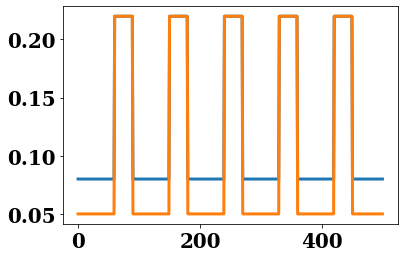

In [101]:
plt.plot(t, beta_dI_h)
plt.plot(t, beta_dI_l)

In [102]:
# sigma = 1/5.
# S, E, I, R = solve_discrete_SEIR((S0, 1*I0, I0, R0), 2*gamma, gamma, sigma, N, tsteps, delta_t=delta_t)
S_dI_h, I_dI_h, H_dI_h, R_dI_h = solve_discrete_SIHR((S0, I0, H0, R0), beta_dI_h, gamma, epsilon, N, tsteps, delta_t=delta_t)
S_dI_l, I_dI_l, H_dI_l, R_dI_l = solve_discrete_SIHR((S0, I0, H0, R0), beta_dI_l, gamma, epsilon, N, tsteps, delta_t=delta_t)
# S, E, I, H, R = solve_discrete_SEIHR((S0, 100, I0, 0, R0), beta, gamma, sigma, epsilon, N, tsteps, delta_t=delta_t)


In [103]:
S_cons, I_cons, H_cons, R_cons = solve_discrete_SIHR((S0, I0, H0, R0), 2.2*gamma, gamma, epsilon, N, tsteps, delta_t=delta_t)

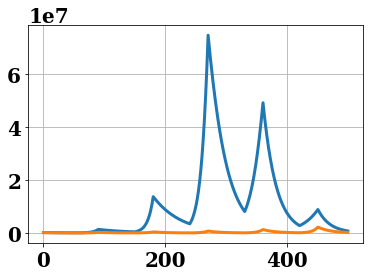

In [104]:
# plt.plot(t, S)
plt.grid()
# plt.yscale("log")
# plt.ylim([1, 1e+9]) 
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
plt.plot(t, I_dI_h)
plt.plot(t, I_dI_l)
# plt.plot(t, R)

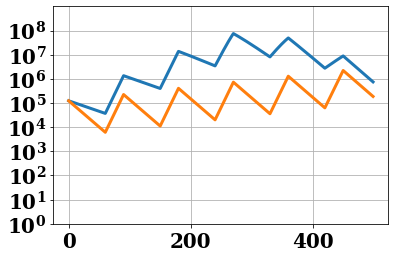

In [105]:
# plt.plot(t, S)
plt.grid()
plt.yscale("log")
plt.ylim([1, 1e+9])
plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
plt.plot(t, I_dI_h)
plt.plot(t, I_dI_l)
# plt.plot(t, R)

In [106]:
def find_approximation(beta, klevels, loss_function):
    """
        Find the best approximation of beta (m,) sized array
        based on one of the klevels (k,) sized array. The
        goodness of approximation is based on 

        loss_function: (y, y_hat) -> R (positive reals)

        Returns: beta_approx (m,) sized array
        such that: 
            
            \sum_t loss_function(beta_approx(t), beta(t))
        i.e. pointwise loss values are minimized.

        Since, loss_function is positive and pointwise,
        elementwise minimum should minimise the global objective.

        TODO: Should we impose some sort of smoothness constraint
        on beta_approx(t) ?
    """
    num_steps = np.shape(beta)[0]
    num_levels = np.shape(klevels)[0]
    
    #TODO: Try out a vectorized implementation
    beta_approx = []
#     lower_buildup = 0
    for t in range(num_steps):
        beta_val = beta[t]
        losses = loss_function(beta_val, klevels)
        best_beta = klevels[np.argmin(losses)]
#         if(lower_buildup > 2 and np.argmin(losses) != num_levels -1):
#             best_beta = klevels[np.argmin(losses)+1]
#             lower_buildup -=1
#         if(lower_buildup < -2 and np.argmin(losses) != 0):
#             best_beta = klevels[np.argmin(losses)-1]
#             lower_buildup +=1
            
#         if(best_beta < beta_val):
#             lower_buildup += 2
#         if(best_beta > beta_val):
#             lower_buildup -= 2
        beta_approx.append(best_beta)

    beta_approx = np.array(beta_approx)
    return beta_approx

In [107]:
S_ideal, I_ideal, R_ideal, beta_ideal = solve_sir_lv_control(S0, I0, R0, beta0, N, r, e, gamma, eta, t)

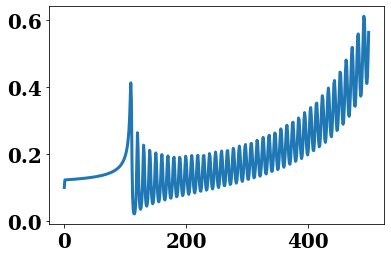

In [108]:
plt.plot(t, beta_ideal)

In [109]:
klevels = np.array([0.1*i for i in range(1,6)])
# klevels = [2.2*gamma, 0.8*gamma]
loss_function = lambda x,y: (x-y)**2
beta_approx = find_approximation(beta_ideal, klevels, loss_function)

In [110]:
S_ideal, I_ideal, H_ideal, R_ideal = solve_discrete_SIHR((S0, I0, H0, R0), beta_ideal, gamma, epsilon, N, tsteps, delta_t=delta_t)
S_approx, I_approx, H_approx, R_approx = solve_discrete_SIHR((S0, I0, H0, R0), beta_approx, gamma, epsilon, N, tsteps, delta_t=delta_t)

In [111]:
df = pd.read_csv('./india_case_counts.csv')
I_real = df.iloc[91:]['Active Infections']

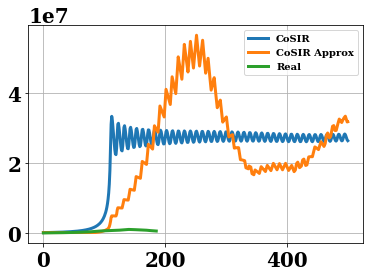

In [112]:
plt.grid()
# plt.yscale("log")
# plt.ylim([1, 1e+9])
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
# plt.plot(t, S, label="CoSIR")
# plt.plot(t, S_approx, label="CoSIR Approx")
# plt.plot(t, S_dI, label = "Dynamic Intervention")
plt.plot(t, I_ideal, label="CoSIR")
plt.plot(t, I_approx, label="CoSIR Approx")
# plt.plot(t, I_cons, label= r'Constant \beta')
# plt.plot(t, I_dI, label = "Dynamic Intervention")
plt.plot(range(len(I_real)), I_real, label = "Real")
plt.legend(prop={'size': 10})
# plt.plot(t, R)

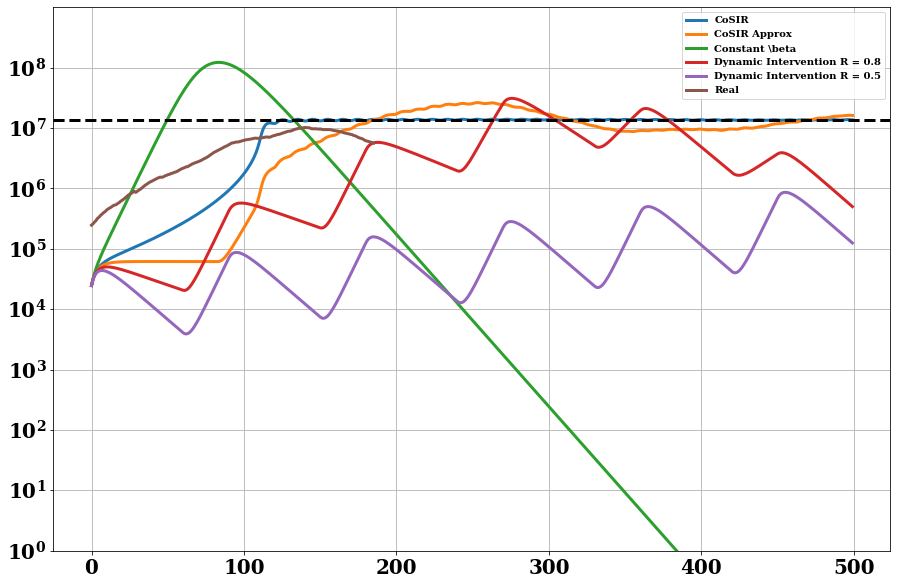

In [113]:
plt.figure(figsize = (15, 10))
plt.grid()
plt.yscale("log")
plt.ylim([1, 1e+9])
plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
# plt.plot(t, S, label="CoSIR")
# plt.plot(t, S_approx, label="CoSIR Approx")
# plt.plot(t, S_dI, label = "Dynamic Intervention")

plt.plot(t, H_ideal, label="CoSIR")
plt.plot(t, H_approx, label="CoSIR Approx")
plt.plot(t, H_cons, label= r'Constant \beta')
plt.plot(t, H_dI_h, label = "Dynamic Intervention R = 0.8")
plt.plot(t, H_dI_l, label = "Dynamic Intervention R = 0.5")
plt.axhline(y=Hstar, linestyle = '--', color = 'black')
plt.plot(range(len(I_real)), I_real*10, label = "Real")
plt.legend(loc = 'upper right', prop={'size': 10})
# plt.plot(t, R)

In [114]:
def getControlMetrics(I, Istar):
    c = 0
    for i in I:
        c += np.abs(i-Istar)
    return c/Istar

In [115]:
# print("Constant beta:{:.2E}".format(getControlMetrics(I_cons, Istar)))
# print("Ideal beta:{:.2E}".format(getControlMetrics(I_ideal, Istar)))
# print("Approx beta:{:.2E}".format(getControlMetrics(I_approx, Istar)))
# print("Dynamic Intervention beta:{:.2E}".format(getControlMetrics(I_dI, Istar)))
# # print("Real:", getControlMetrics(I_real[:180], Istar))

In [122]:
l = len(I_real)
print("Constant beta: {}".format(getControlMetrics(H_cons[:l], Hstar)))
print("Ideal beta: {}".format(getControlMetrics(H_ideal[:l], Hstar)))
print("Approx beta: {}".format(getControlMetrics(H_approx[:l], Hstar)))
print("Dynamic Intervention beta R=0.8: {}".format(getControlMetrics(H_dI_h[:l], Hstar)))
print("Dynamic Intervention beta R=0.5: {}".format(getControlMetrics(H_dI_l[:l], Hstar)))
print("Real: {}".format(getControlMetrics(I_real, Hstar)))

Constant beta: 393.79442890916283
Ideal beta: 109.41084262655487
Approx beta: 149.91338561769885
Dynamic Intervention beta R=0.8: 179.03345301561265
Dynamic Intervention beta R=0.5: 185.54807900365586
Real: 179.29424338459356


In [123]:
print("Constant beta: {}".format(getControlMetrics(H_cons, Hstar)))
print("Ideal beta: {}".format(getControlMetrics(H_ideal, Hstar)))
print("Approx beta: {}".format(getControlMetrics(H_approx, Hstar)))
print("Dynamic Intervention beta R=0.8: {}".format(getControlMetrics(H_dI_h, Hstar)))
print("Dynamic Intervention beta R=0.5: {}".format(getControlMetrics(H_dI_l, Hstar)))

Constant beta: 707.2968996000648
Ideal beta: 112.44520877596158
Approx beta: 259.7025420547946
Dynamic Intervention beta R=0.8: 379.03951753430243
Dynamic Intervention beta R=0.5: 495.1927643299237


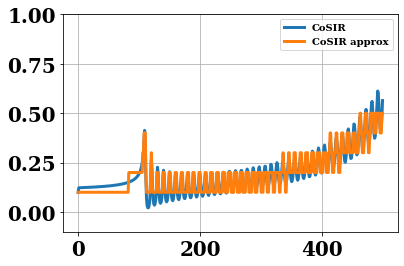

In [117]:
plt.grid()
# plt.yscale("log")
plt.ylim([-0.1, 1])
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
plt.plot(t, beta_ideal, label="CoSIR")
plt.plot(t, beta_approx, label="CoSIR approx")
# plt.plot(t, beta_dI_h, label = "Dynamic Intervention")
plt.legend(prop={'size': 10})
# plt.plot(t, R)

In [118]:
J_ideal = [beta_ideal[i]*S_ideal[i] for i in range(len(S_ideal))]

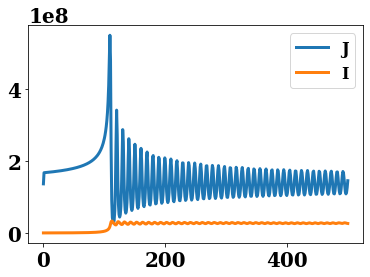

In [120]:
plt.plot(t, J_ideal, label= "J")
plt.plot(t, I_ideal, label= "I")
plt.legend()